100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


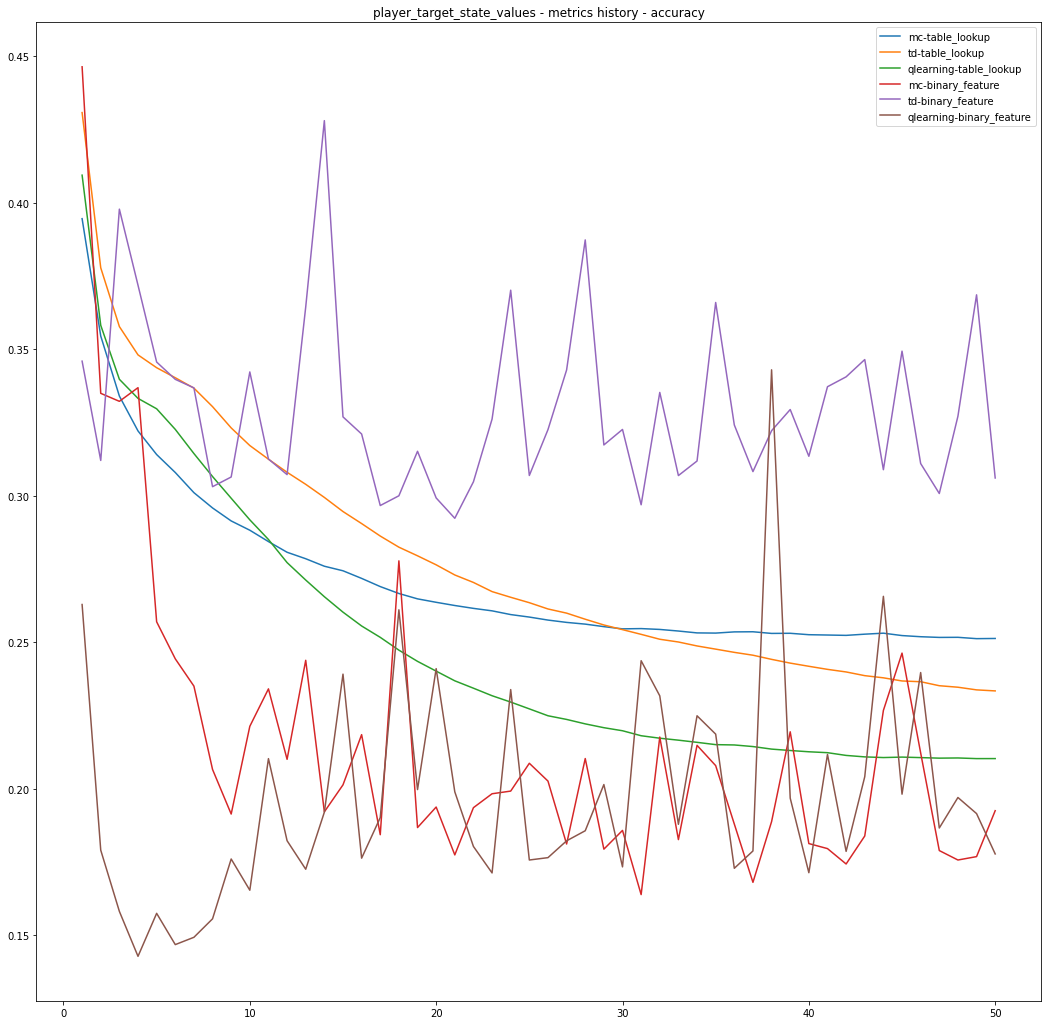

In [4]:
# TASK:
# - check table_lookup/full_binary_feature, td/mc, on/off-policy ~ convergence
#
# PROCESS;
# - sample EPISODES experiences with different feature functions and control
# - replay experience to fit with value approximator with different configs
#
# RESULTS:
# - mc-table_lookup - converge
# - td-table_lookup - converge
# - qlearning-table_lookup - converge
# - mc-binary_feature - converge*
# - td-binary_feature - converge*
# - qlearning-binary_feature - not converge
#
# EXPECTATION:
# for controls:
# - mc-table_lookup: converge
# - td-table_lookup: converge
# - qlearning-table_lookup: converge
# - mc-binary_feature: near-optimal (sampling not optimal)
# - td-binary_feature: near-optimal (sampling not optimal)
# - qlearning-binary_feature: not converge
# for learning/evaluation:
# - mc-binary_feature: converge
# - td-binary_feature: converge
# - qlearning-binary_feature: not converge
# extra:
# - (gradient_qlearning-table_lookup: converge)
# - (gradient_qlearning-binary_feature: converge)
# - (*-non-linear-approximation: not converge)
#
# INTERPRETATION:
# - RESULTS are aligning with EXPECTATION
# - mc learning with linear approximation of binary_feature
#   can achieve better accuracy than table_lookup when sampling
#   is not sufficient
#
# REFERENCES:
# - as per L6 of David Silver*, TD doesn't follow the gradient of any objective
#   function, therefore it can diverge when off-policy or using non-linear
#   function approximation.
# - Gradient TD follows true gradient of projected Bellman error
# - for linear function approximation, the optimal(least square solution)
#   can be solved directly with LSMC, LSTD, LSTD(lambda);
#   LSTDQ/LSPI(Least Square Policy Iteration) can converge to near-optimal,
#   but it doesn't work with non-linear function approximation
# * https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf
#
# RUN:
# %%
import sys

sys.path.append("../")

from tqdm import trange
from random import shuffle

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS, STATE_LABELS, PLAYER_STATES
from src.easy_21.feature_function import table_lookup, full_binary_feature

#
# hyperparameters and agent config
#

EPISODES = int(1e4)

EPOCH = 50

PLAYER = ModelFreeAgent(
    "player",
    ACTIONS,
    STATE_LABELS,
    PLAYER_STATES,
    state_action_parser=table_lookup,
)
PLAYER.load_optimal_state_values()

PLAYER.target_state_value_store.metrics_methods[
    "accuracy"
] = PLAYER.target_state_value_store_accuracy_to_optimal

#
# process
#

lambda_off_policy_configs = [(1, False), (0, False), (0, True)]
feature_function_options = [table_lookup, full_binary_feature]

for feature_function in feature_function_options:

    PLAYER.action_value_store.feature_function = feature_function

    for (lambda_value, off_policy) in lambda_off_policy_configs:

        PLAYER.action_value_store.reset()

        experiences = [
            playout(player_policy=PLAYER.e_greedy_policy)[0] for _ in trange(EPISODES)
        ]

        for _ in trange(EPOCH):
            shuffle(experiences)
            PLAYER.forward_td_lambda_learning_offline_batch(
                experiences,
                lambda_value=lambda_value,
                off_policy=off_policy,
            )

            PLAYER.target_state_value_store.record("accuracy", log=False)

        PLAYER.target_state_value_store.stack_metrics_history("accuracy")

labels = [
    "mc-table_lookup",
    "td-table_lookup",
    "qlearning-table_lookup",
    "mc-binary_feature",
    "td-binary_feature",
    "qlearning-binary_feature",
]
PLAYER.target_state_value_store.plot_metrics_history_stack(
    "accuracy",
    labels=labels,
)
